In [118]:
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import json
import sys
import statsmodels.api as sm
import os
import kad.visualization.visualization as visualization
import kad.kad_utils.kad_utils as kad_utils
import kad.models_evaluation.models_evaluator as models_evaluator

sys.path.insert(1, '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector')
print(sys.path)

import kad.model_selector.model_selector as model_sclector
from kad.model import i_model
from kad.model import sarima_model
from kad.data_processing import downsampler, upsampler, composite_data_processor
from sklearn.model_selection import train_test_split

kad_utils.customize_matplotlib()

['/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/notebooks', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload'

# Reading data

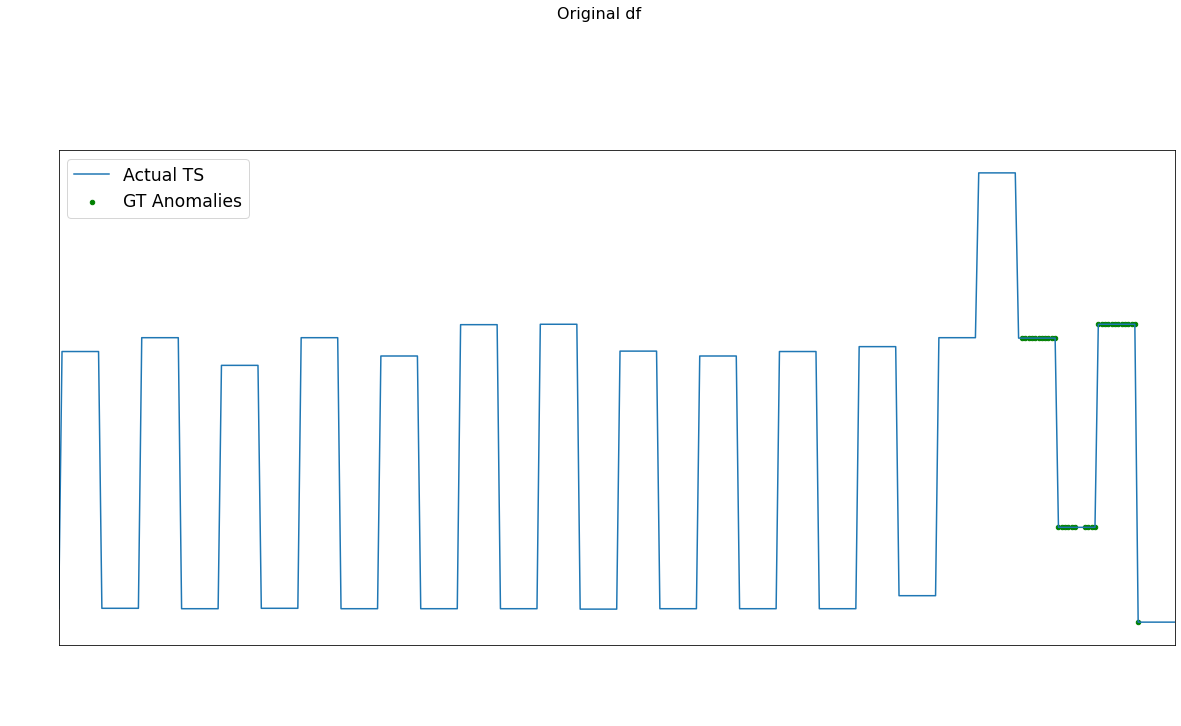

In [119]:
data_dir = "data/archive/"
# file_dir = "artificialWithAnomaly"
# file_name = "artificialWithAnomaly/art_daily_flatmiddle.csv"
file_dir = "realAWSCloudwatch"
file_name = "realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv"

file_path = os.path.join(data_dir, file_dir, file_name)

original_df = pd.read_csv(
    file_path, parse_dates=True, index_col="timestamp"
)

data_proc = composite_data_processor.CompositeDataProcessor([downsampler.Downsampler("12h", np.max), upsampler.Upsampler("1h")])
original_df = data_proc.transform_data(original_df)

with open("data/archive/combined_windows.json") as f:
    true_anomalies = json.load(f)

X_LABEL = "timestamp"

true_anomalies_ranges = true_anomalies[file_name]

ground_true_anomalies_df = pd.DataFrame()
for anom_range in true_anomalies_ranges:
    ground_true_anomalies_df = ground_true_anomalies_df.append(original_df.loc[anom_range[0]:anom_range[1]])

preprocessed_df = original_df.copy()
preprocessed_df["gt_is_anomaly"] = [idx in ground_true_anomalies_df.index for idx in original_df.index.tolist()]

visualization.visualize(results_df=preprocessed_df, metric_name="value", title="Original df")

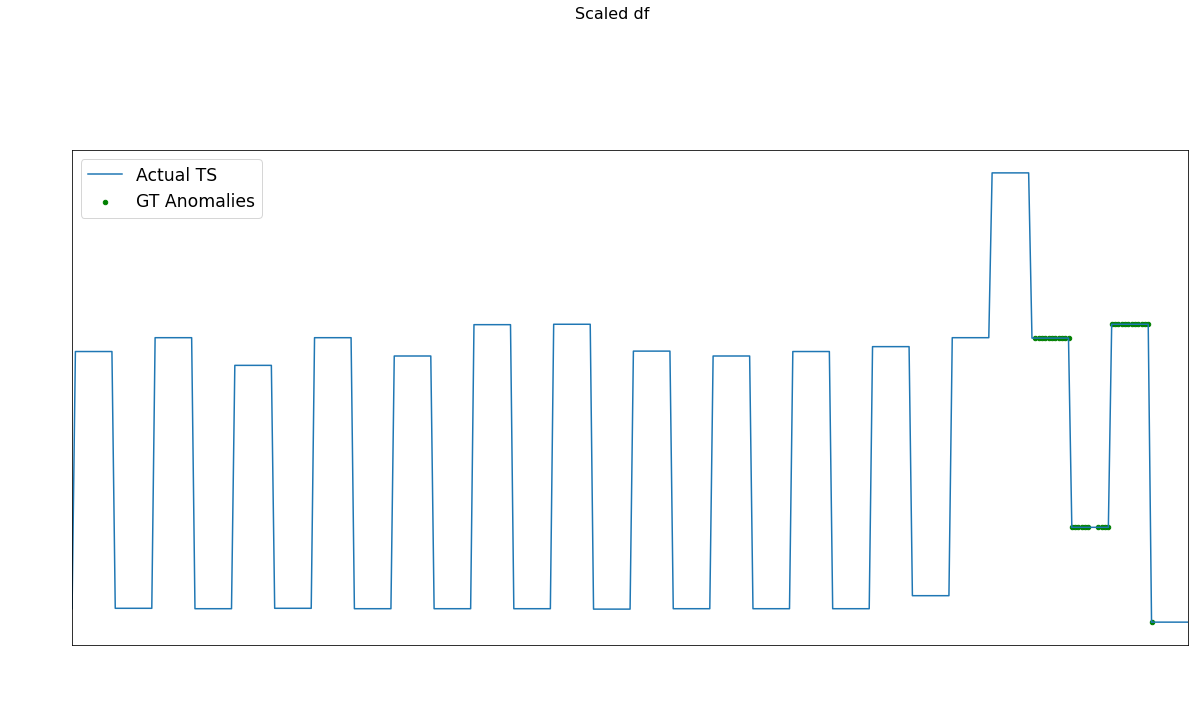

In [120]:
scaler = MinMaxScaler(feature_range=(-1, 0))
preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

visualization.visualize(results_df=preprocessed_df, metric_name="value", title="Scaled df")

In [121]:
values_df = preprocessed_df[["value"]]
mod_sel = model_sclector.ModelSelector(values_df)
print("Is TS stationary: ", mod_sel.is_stationary())


Statistics analysis

Statistic Test :  -2.430318880619925
p-value :  0.13336131568138215
# n_lags :  12
No of observation:  324
 critical value 1% : -3.450695263332383
 critical value 5% : -2.87050218926466
 critical value 10% : -2.5715449066453284
Is TS stationary:  False


In [122]:
# f = plt.figure(figsize=(20, 10))
# ax = f.add_subplot(2, 1, 1)
# _ = sm.graphics.tsa.plot_acf(values_df, lags=100, ax=ax)
# ax2 = f.add_subplot(2, 1, 2)
# _ = sm.graphics.tsa.plot_pacf(values_df, lags=50, ax=ax2)
# f.suptitle("ACF & PACF")

In [123]:
dominant_freq = mod_sel.calculate_dominant_frequency()

# SARIMA

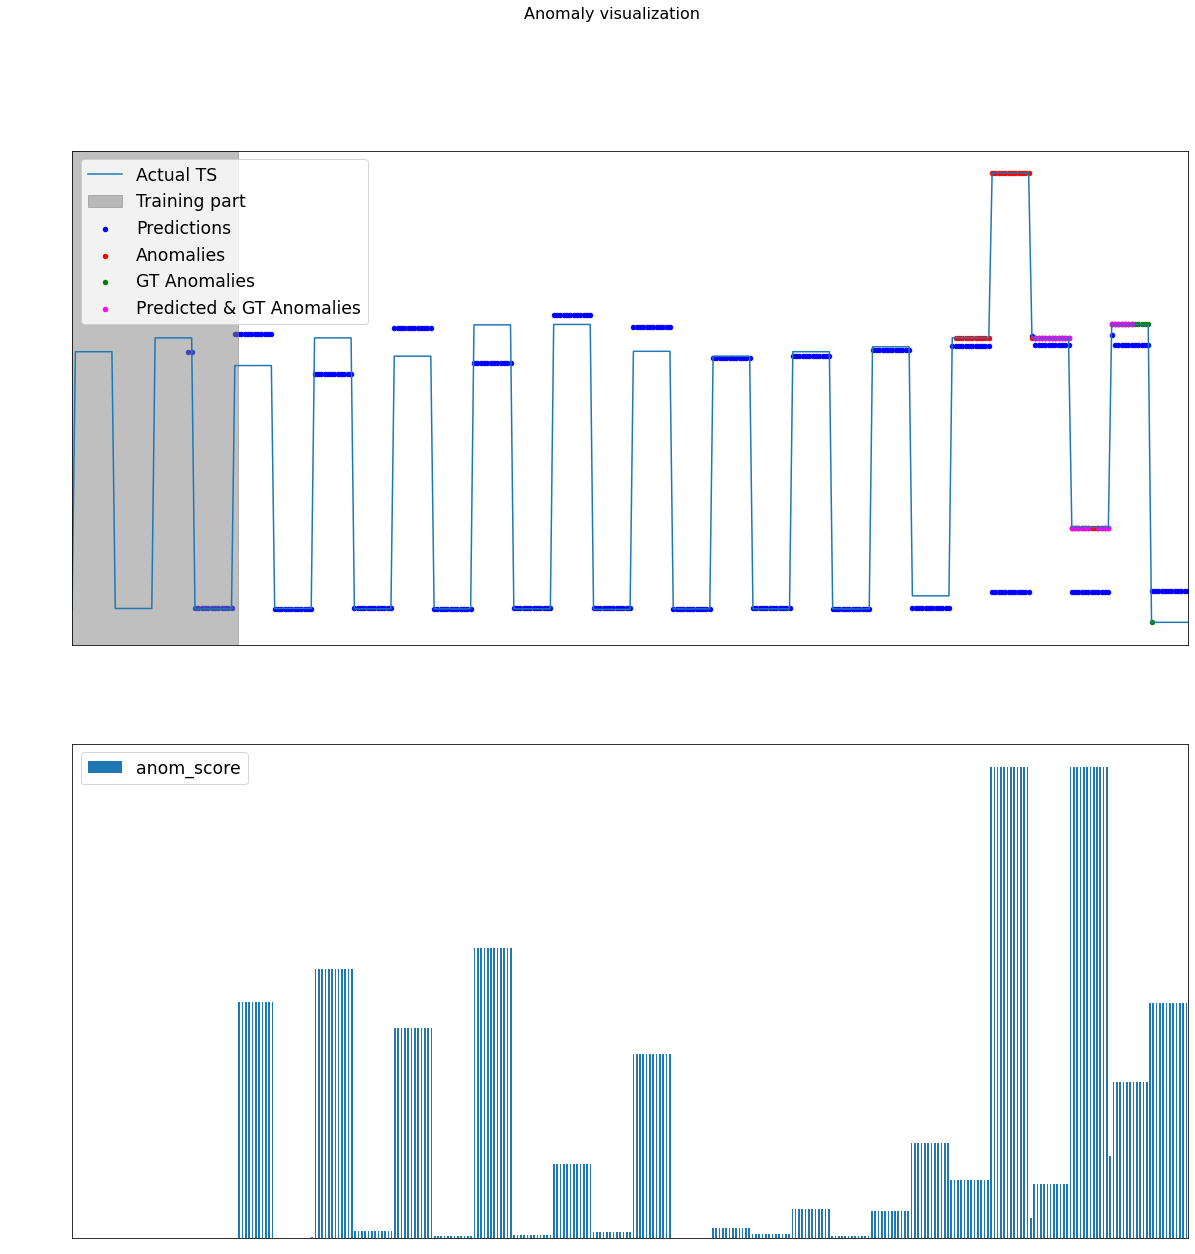

In [124]:
sarima_model = importlib.reload(sarima_model)
kad_utils = importlib.reload(kad_utils)

model: i_model.IModel = sarima_model.SarimaModel(order=(0, 0, 0), seasonal_order=(1, 0, 1, dominant_freq))

# warnings.filterwarnings("ignore")
train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
val_err = model.train(train_df)

results_df = pd.DataFrame()
SAMPLES_TO_PREDICT = 18
for i in range(0, len(test_df), SAMPLES_TO_PREDICT):
    results_df = model.test(test_df.iloc[i:i + SAMPLES_TO_PREDICT])

visualization = importlib.reload(visualization)
evaluation_df = results_df.copy()
evaluation_df["gt_is_anomaly"] = preprocessed_df["gt_is_anomaly"]
visualization.visualize(evaluation_df, metric_name="value", last_train_sample=len(train_df))

Accuracy:  0.89
Avg precision:  0.27
Recall:  0.82
1st:  1.0
1.992950656306424
2nd:  1.0


<ipython-input-125-f89f4900884c>:3: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  evaluation_df = evaluation_df.loc[test_df.index & evaluation_df.index]


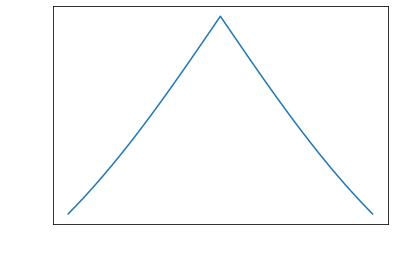

3rd:  0.8834316836348504
1.992950656306424


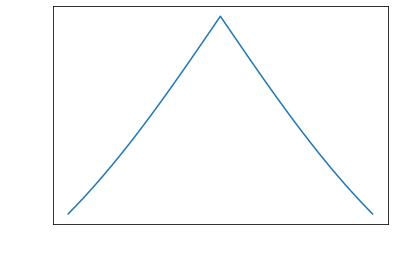

Score:  0.9611438945449501


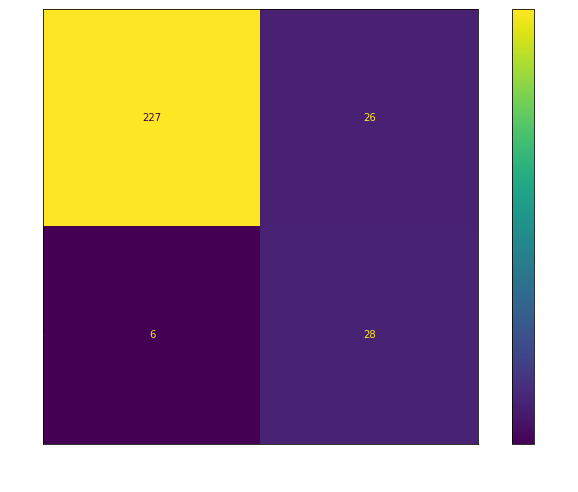

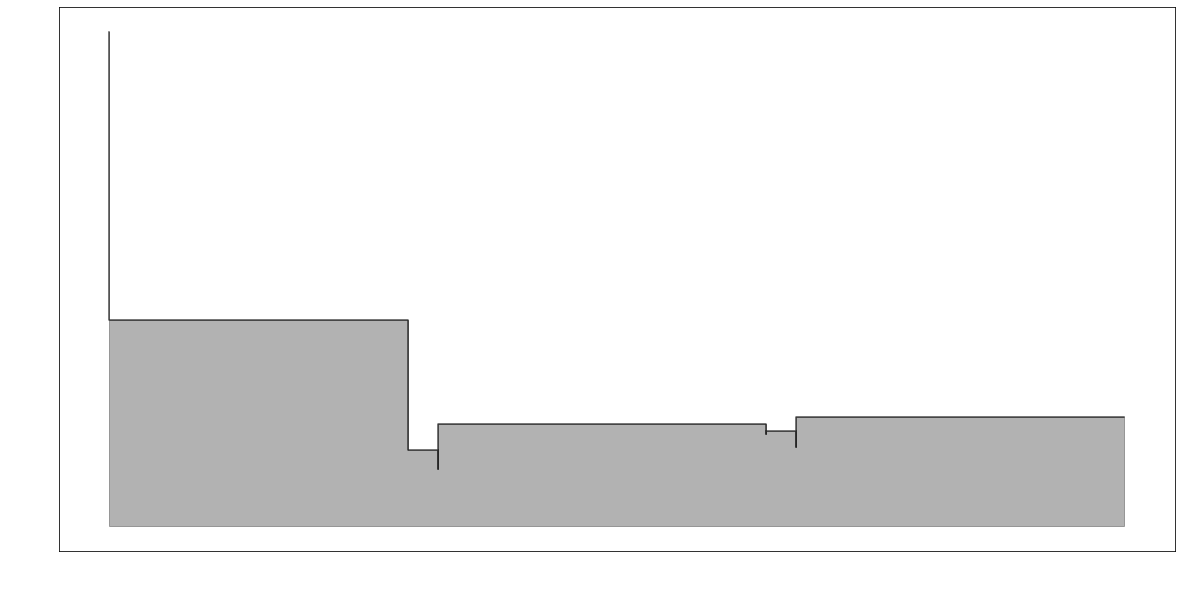

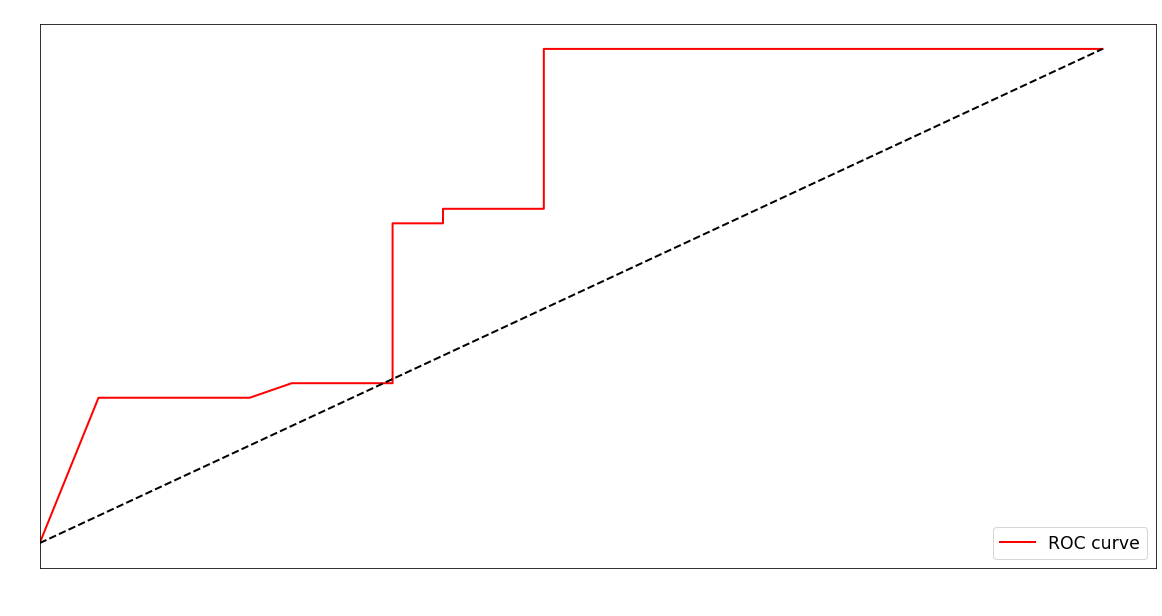

In [125]:
models_evaluator = importlib.reload(models_evaluator)

evaluation_df = evaluation_df.loc[test_df.index & evaluation_df.index]
evaluator = models_evaluator.ModelsEvaluator(df=evaluation_df)

print("Accuracy: ", evaluator.get_accuracy())
print("Avg precision: ", evaluator.get_average_precision())
print("Recall: ", evaluator.get_recall_score())
print("Score: ", evaluator.get_customized_score())

evaluator.plot_confusion_matrix()

evaluator.plot_precision_recall_curve()
evaluator.plot_roc()